In [1]:
import pandas as pd
import numpy as np
import os
from os.path import isfile, join
import xml.etree.ElementTree as ET
import copy
import matplotlib.pyplot as plt
from matplotlib import rcParams

os.chdir('../')

from res.dispatcher import Dispatcher

rcParams["errorbar.capsize"] = 8.
#rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = '14'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [2]:
main_folder = '../data/online/instance21/iterations/'
iteration_folders = [os.path.join(main_folder, i) for i in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, i))]

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../data/online/instance21/iterations/'

In [3]:
def get_data(tree, d):
    for meas in tree:
        m = meas.attrib
        ev_id = int(m['id'])
        data = d[ev_id]
        data['init_time'].append(float(m['init_operation_time']))
        data['end_time'].append(float(m['arrival_time']))
        data['consumption'].append(float(m['consumption_since_start']))
        data['total_time'].append(float(m['arrival_time']) - float(m['init_operation_time']))
    return d

In [4]:
data0 = {'init_time': [], 'end_time': [], 'total_time':[], 'consumption': []}
data1 = {'init_time': [], 'end_time': [], 'total_time':[], 'consumption': []}
opt_data = {0: data0, 1: data1}
nopt_data = copy.deepcopy(opt_data)
for iteration_folder in iteration_folders:
    # with opt
    path = iteration_folder +'/opt/collection.xml'
    opt_tree = ET.parse(path).getroot()
    opt_data = get_data(opt_tree, opt_data)
    
    
    # without opt
    path = iteration_folder +'/no_opt/collection.xml'
    no_opt_tree = ET.parse(path).getroot()
    no_opt_data = get_data(no_opt_tree, nopt_data)
    
opt0_df = pd.DataFrame(opt_data[0])
opt1_df = pd.DataFrame(opt_data[1])
nopt0_df = pd.DataFrame(no_opt_data[0])
nopt1_df = pd.DataFrame(no_opt_data[1])

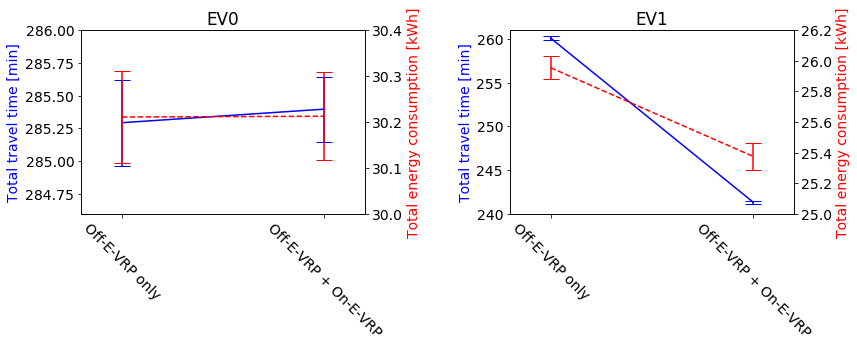

In [97]:
fig, (axtime, axec) = plt.subplots(1, 2, figsize=(12,5))

# EV 0
id_ev = 0

avg_time_opt = np.mean(opt_data[id_ev]['total_time'])
std_time_opt = np.std(opt_data[id_ev]['total_time'])
avg_time_nopt = np.mean(nopt_data[id_ev]['total_time'])
std_time_nopt = np.std(nopt_data[id_ev]['total_time'])

avg_ec_opt = np.mean(opt_data[id_ev]['consumption'])
std_ec_opt = np.std(opt_data[id_ev]['consumption'])
avg_ec_nopt = np.mean(nopt_data[id_ev]['consumption'])
std_ec_nopt = np.std(nopt_data[id_ev]['consumption'])

ax0 = axtime
ax1 = ax0.twinx()

ax0.errorbar([0, 1], [avg_time_nopt, avg_time_opt], [std_time_nopt, std_time_opt], color='b')
ax1.errorbar([0, 1], [avg_ec_nopt, avg_ec_opt], [std_ec_nopt, std_ec_opt], color='r', linestyle='--', fmt='--')

ax0.set_ylabel('Total travel time [min]', color='b')
ax1.set_ylabel('Total energy consumption [kWh]', color='r')

ax0.set_xticks([0, 1])
ax0.set_xticklabels(['Off-E-VRP only', 'Off-E-VRP + On-E-VRP'], rotation=-45)

ax0.set_ylim(284.6, 286)
ax1.set_ylim(30., 30.4)

ax0.set_xlim(-.2, 1.2)

ax0.set_title(f'EV{id_ev}')

# EV 1
id_ev = 1

avg_time_opt = np.mean(opt_data[id_ev]['total_time'])
std_time_opt = np.std(opt_data[id_ev]['total_time'])
avg_time_nopt = np.mean(nopt_data[id_ev]['total_time'])
std_time_nopt = np.std(nopt_data[id_ev]['total_time'])

avg_ec_opt = np.mean(opt_data[id_ev]['consumption'])
std_ec_opt = np.std(opt_data[id_ev]['consumption'])
avg_ec_nopt = np.mean(nopt_data[id_ev]['consumption'])
std_ec_nopt = np.std(nopt_data[id_ev]['consumption'])

ax0 = axec
ax1 = ax0.twinx()

l0 = ax0.errorbar([0, 1], [avg_time_nopt, avg_time_opt], [std_time_nopt, std_time_opt], color='b', label='Total travel time')
l1 = ax1.errorbar([0, 1], [avg_ec_nopt, avg_ec_opt], [std_ec_nopt, std_ec_opt], fmt='r--', label='Total energy consumption')

ax0.set_ylim(240, 261)
ax1.set_ylim(25, 26.2)

ax0.set_xlim(-.2, 1.2)

ax0.set_ylabel('Total travel time [min]', color='b')
ax1.set_ylabel('Total energy consumption [kWh]', color='r')

ax0.set_xticks([0, 1])
ax0.set_xticklabels(['Off-E-VRP only', 'Off-E-VRP + On-E-VRP'], rotation=-45)

ax0.set_title(f'EV{id_ev}')

plt.tight_layout()
plt.show()
fig.savefig(main_folder+'comparison.pdf')

In [6]:
nopt1_df

,init_time,end_time,total_time,consumption
0,796.298401,1057.068575,260.770174,25.937423
1,796.298401,1056.324698,260.026296,26.032449
2,796.298401,1056.388213,260.089812,25.857449
3,796.298401,1056.488585,260.190184,25.995363
4,796.298401,1056.157120,259.858719,26.069678
5,796.298401,1056.189871,259.891470,25.846442
6,796.298401,1056.069887,259.771486,25.944040
7,796.298401,1056.471994,260.173593,25.881444
8,796.298401,1056.202240,259.903839,25.969318
9,796.298401,1056.592579,260.294177,25.887213


## Online folder locations

In [2]:
# Specify locations
offline_folder = 'data/online/instance21/offline/'
online_folder = 'data/online/instance21/online/'

## Costs

In [51]:
# Function to get costs' dataframes
def get_costs_dataframes(folder, weights=None):
    folders = [os.path.join(folder, i) for i in os.listdir(folder) if os.path.isdir(os.path.join(folder, i))]
    columns = ['consumed_energy', 'recharging_cost', 'recharging_time', 'travelled_time', 'total']
    df = pd.DataFrame(columns=columns)
    for folder in folders:
        history_path = folder + '/history.xml'
        root = ET.parse(history_path)
        _fleet: ET.Element = root.find('fleet')
        row_dict = {key: [float(attr)] for key, attr in _fleet.attrib.items()}
        costs = (row_dict['travelled_time'][0], row_dict['consumed_energy'][0]/24., row_dict['recharging_time'][0], row_dict['recharging_cost'][0])
        if weights is None:
            total_cost = sum(costs)
        else:
            total_cost = np.dot(np.asarray(costs), np.asarray(weights))  
        row_dict['total'] = total_cost
        row = pd.DataFrame(row_dict)
        df = df.append(row, ignore_index=True)
    
    return df.dropna()


weights = (0.1 / 2.218, 1. / 0.4364, 1. / 100, 1. / 500)

In [63]:
# Get offline costs
off_df = get_costs_dataframes(offline_folder, weights)

off_statistics = off_df.describe()
off_statistics

,consumed_energy,recharging_cost,recharging_time,travelled_time,total
count,50.000000,5.000000e+01,50.000000,50.000000,50.000000
mean,56.349847,1.402551e+05,79.274305,289.113191,299.718060
std,1.951541,2.939931e-11,3.283526,8.656114,0.418826
min,50.714917,1.402551e+05,74.252721,274.017076,298.833198
25%,55.551899,1.402551e+05,77.667056,283.952004,299.464576
50%,56.810814,1.402551e+05,79.114996,288.269628,299.679149
75%,57.771591,1.402551e+05,80.303698,293.979369,299.935006
max,59.155571,1.402551e+05,96.820290,311.804154,300.805131


In [64]:
# Get online costs
on_df = get_costs_dataframes(online_folder, weights)

on_statistics = on_df.describe()
on_statistics

,consumed_energy,recharging_cost,recharging_time,travelled_time,total
count,42.000000,42.000000,42.000000,42.000000,42.000000
mean,52.654129,139983.489951,76.805018,283.981895,298.565861
std,3.255598,23347.135307,12.873743,20.643993,47.520373
min,46.131770,84538.148734,44.755491,238.203822,185.564476
25%,50.648289,123395.640779,69.353249,270.854409,264.489244
50%,52.514320,138966.706651,76.284578,281.531507,296.893569
75%,54.816222,148476.860030,83.242286,301.371936,316.958372
max,58.046688,225495.242751,119.379834,320.206790,471.979877


[Text(0, 0, 'Off-E-VRP only'), Text(0, 0, 'Off-E-VRP + On-E-VRP')]

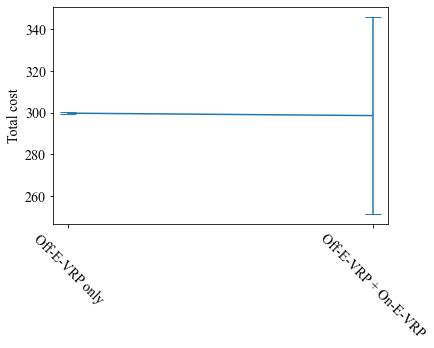

In [69]:
def get_mean_std(df, column_name):
    mean = df[column_name]['mean']
    std = df[column_name]['std']
    return mean, std

mean_off, std_off = get_mean_std(off_statistics, 'total')
mean_on, std_on = get_mean_std(on_statistics, 'total')


fig = plt.figure()
plt.errorbar([0, 1], [mean_off, mean_on], yerr=[std_off, std_on])

plt.ylabel('Total cost')

ax = plt.gca()
ax.set_xticks([0, 1])
ax.set_xticklabels(['Off-E-VRP only', 'Off-E-VRP + On-E-VRP'], rotation=-45)

In [71]:
print(mean_off, mean_on)

299.7180597176468 298.565861121058


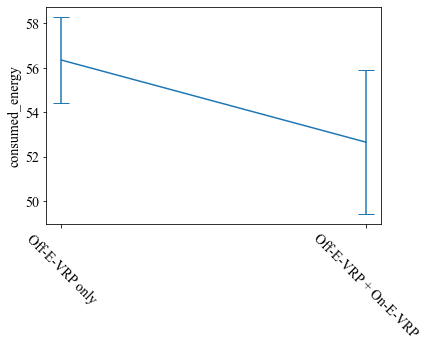

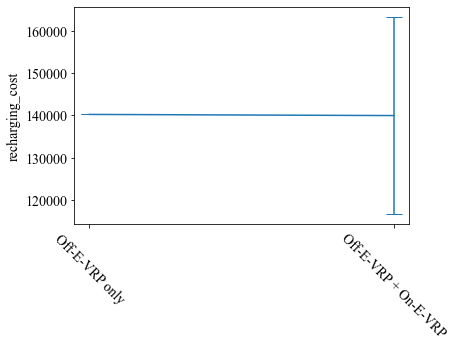

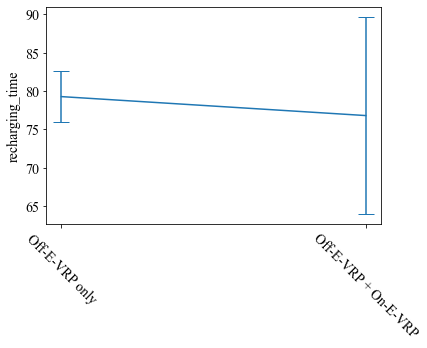

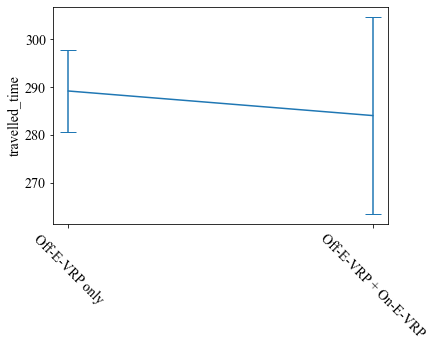

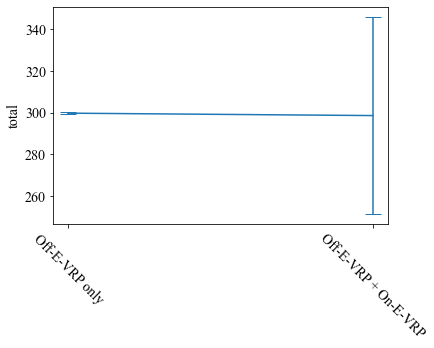

In [70]:
for column in off_statistics.columns:
    mean_off, std_off = get_mean_std(off_statistics, column)
    mean_on, std_on = get_mean_std(on_statistics, column)
    
    fig = plt.figure()
    
    plt.errorbar([0, 1], [mean_off, mean_on], yerr=[std_off, std_on])
    
    plt.ylabel(column)

    ax = plt.gca()
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Off-E-VRP only', 'Off-E-VRP + On-E-VRP'], rotation=-45)

## Constraints violations

In [60]:
# Function to get costs' dataframes
def get_constraints_dataframes(folder):
    folders = [os.path.join(folder, i) for i in os.listdir(folder) if os.path.isdir(os.path.join(folder, i))]
    columns = ['time_window_down', 'time_window_upp', 'alpha_up', 'alpha_down', 'max_tour_time', 'total']
    df = pd.DataFrame(columns=columns)
    for folder in folders:
        history_path = folder + '/history.xml'
        root = ET.parse(history_path)
        for _vehicle in root.iter('vehicle'):
            _violated_constraints = _vehicle.find('violated_constraints')
            for _violated_constraint in _violated_constraints:
                row = {key: 0 for key in columns}
                row[_violated_constraint.attrib['type']] = 1
                row['total'] = 1
                df = df.append(row, ignore_index=True)
    return df.dropna().sum()

In [61]:
get_constraints_dataframes(offline_folder)

time_window_down      0.0
time_window_upp      54.0
alpha_up              2.0
alpha_down          111.0
max_tour_time         0.0
total               167.0
dtype: float64

In [62]:
get_constraints_dataframes(online_folder)

time_window_down     0.0
time_window_upp     15.0
alpha_up             0.0
alpha_down          14.0
max_tour_time        0.0
total               29.0
dtype: float64